In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from lstm2 import LSTMModel
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss

(5000, 50, 1)


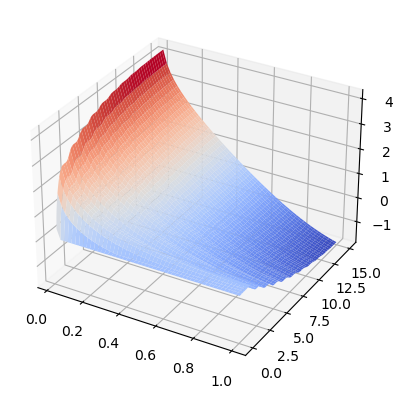

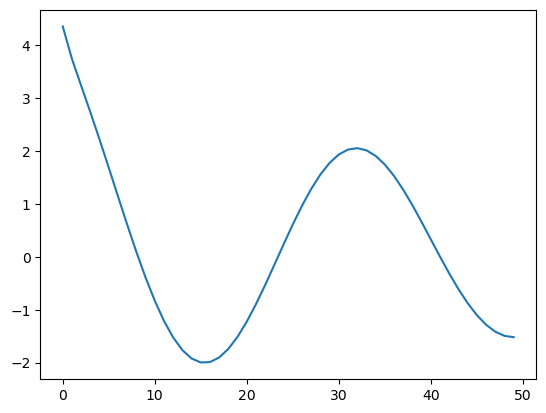

In [2]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000
sampleRate = 29*2

t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("thetaHat.mat")["tHatData"]
x = x.reshape(npoints, nt,nx).astype(np.float32)
y = scipy.io.loadmat("gain.mat")["gainData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    
xArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
yArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, x[0, :, :], cmap=cm.coolwarm)

for i in range(npoints):
    for j in range(int(nt/sampleRate)):
        for k in range(nx):
            xArr[i*int(nt/sampleRate)+j] = x[i, int(j*sampleRate), :]
            yArr[i*int(nt/sampleRate)+j] = y[i, int(j*sampleRate), :]
x=xArr.reshape((npoints*int(nt/sampleRate), nx, 1))
y=yArr.reshape((npoints*int(nt/sampleRate), nx, 1))

plt.figure()
plt.plot(xArr[28])
print(x.shape)
#plt.figure()
#plt.plot(y[0])

In [3]:
# Parameters
epochs =1000
ntrain = 900
ntest = 100
batch_size = 50
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes = 12
width = 32

In [4]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

# Normalize
#x_normalizer = UnitGaussianNormalizer(x_train)
#y_normalizer = UnitGaussianNormalizer(y_train)
#x_train  = x_normalizer.encode(x_train)
#x_test = x_normalizer.encode(x_test)
#y_train = y_normalizer.encode(y_train)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [5]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [6]:
#model = LSTMModel(100, 1024, 100, 1, 3, [512, 128, 64]).cuda()
model = LSTMModel(500, 1,1).cuda()
print(count_params(model))

1006501


In [7]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
t = default_timer()

loss = LpLoss()
train_mseArr = []
test_mseArr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        #out = y_normalizer.decode(out)
        #y = y_normalizer.decode(y)
        mse = loss(out, y)
        mse.backward()
        
        optimizer.step()
        train_mse += mse.item()
        
    scheduler.step()
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            #out = y_normalizer.decode(out)
            test_mse += loss(out, y).item()
            
    train_mse /= len(trainData)
    test_mse /= len(testData)
    
    train_mseArr.append(train_mse)
    test_mseArr.append(test_mse)
    
    t2 = default_timer()
    if ep%50 == 0:
        print(ep, t2-t1, train_mse, test_mse)
print(default_timer()-t)

0 0.4157861298881471 0.6490775230858061 0.330951988697052
50 0.2318569626659155 0.016581180743459198 0.014853520970791578
100 0.23469440080225468 0.010160723856339851 0.010259965434670448
150 0.23255118215456605 0.007522336807515886 0.006794982217252254
200 0.23237882321700454 0.005005918673446609 0.00486649819649756
250 0.2767507960088551 0.00403978080333521 0.004028781014494598
300 0.23490032320842147 0.003587399200639791 0.0037567663937807085
350 0.23579972004517913 0.0033680068199626275 0.003467496484518051
400 0.23540361179038882 0.003251109298111664 0.0033583370968699455
450 0.23559289518743753 0.0031814441990314257 0.0032667975872755052
500 0.23556274501606822 0.0031423510854235955 0.0032425949349999426
550 0.2358350339345634 0.003118648729287088 0.003206646558828652
600 0.2351891747675836 0.0031082825554120874 0.0032067584106698632
650 0.2416216479614377 0.0031025423176793587 0.0031933832447975873
700 0.23738453024998307 0.003099770867265761 0.0031903656898066403
750 0.23590205

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


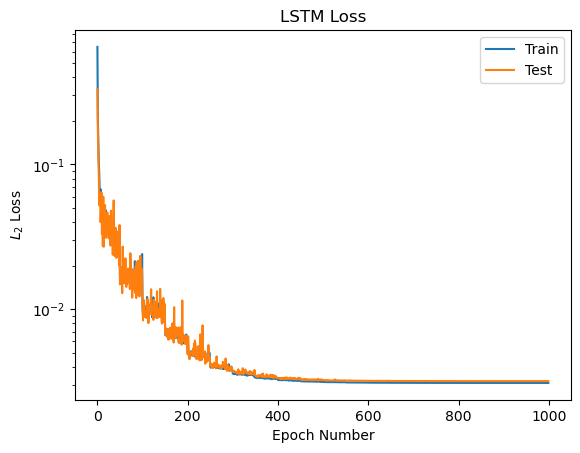

In [16]:
plt.title("LSTM Loss")
plt.plot(train_mseArr, label="Train")
plt.plot(test_mseArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.legend()
plt.savefig('lstm.eps')

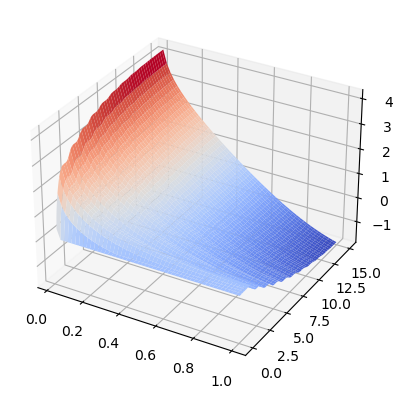

In [17]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000
sampleRate = 29*2

t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("thetaHat.mat")["tHatData"]
x = x.reshape(npoints, nt,nx).astype(np.float32)
y = scipy.io.loadmat("gain.mat")["gainData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    
xArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
yArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, x[0, :, :], cmap=cm.coolwarm)


In [18]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 100
modes = 12
width = 64

In [19]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()


trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [20]:
with torch.no_grad():
    test_mse = 0
    mse_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
        outTensor = torch.from_numpy(np.zeros((batch_size, x.shape[1], x.shape[2]), dtype=np.float32)).cuda()
        for timeStep in range(x.shape[1]):
            out = model(x[:, timeStep, :].reshape(batch_size, x.shape[2], 1))
            outTensor[:, timeStep, :] = out.reshape(batch_size, x.shape[2])

        test_mse += loss(outTensor, y).item()
print("TEST MSE For " + str(batch_size) + " Instances:", test_mse/len(testData))

TEST MSE For 20 Instances: 0.005513813626021147


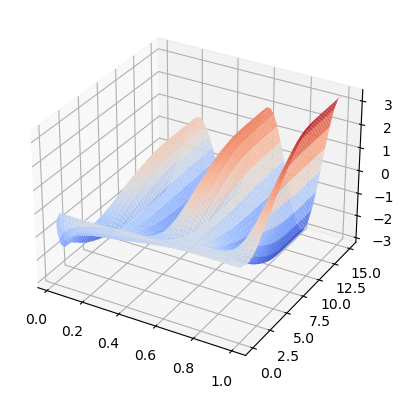

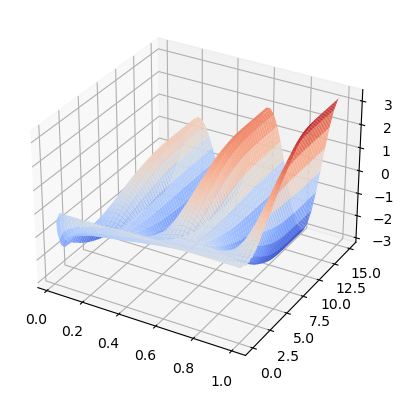

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, outTensor[2, :, :].detach().cpu().numpy(), cmap=cm.coolwarm)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, y[2, :, :].detach().cpu().numpy(), cmap=cm.coolwarm)

In [22]:
torch.save(model.state_dict(), 'lstmModel2')